Import Drive to import our image dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1.Data preprocessing**

In [ ]:
#to split our dataset of images into training, validation and test sets
pip install split-folders


lecture des donnees

In [ ]:
#!zip -d "/content/drive/My Drive/data/dataset.zip" "__MACOSX*"


	zip warning: name not matched: __MACOSX*

zip error: Nothing to do! (/content/drive/My Drive/data/dataset.zip)


In [ ]:
#!unzip -uq "/content/drive/My Drive/data/dataset.zip" -d "/content/drive/My Drive/data"


In [ ]:
dataset = "/content/drive/My Drive/data/dataset"
output = "/content/drive/My Drive/out"

Splitting dataset 

In [ ]:
import splitfolders  # or import split_folders

# Split with a ratio. (80% training, 10% val, 10% test)
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(dataset, output=output, seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed(dataset, output=output, seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values

Copying files: 2043 files [21:19,  1.60 files/s]
Copying files: 2043 files [00:26, 76.98 files/s]


In [ ]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
import keras
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import ResNet152V2, InceptionResNetV2, InceptionV3, Xception, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from keras import regularizers

import matplotlib.pyplot as plt

#!pip install efficientnet
#import efficientnet.tfkeras as efn

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


Creation of CSV files for training, val and test sets

In [ ]:
import pandas as pd
import os


df_train = pd.DataFrame()

filenames = []

directory = []

label = []
TrainClass1Path = '/content/drive/MyDrive/out/train/1-PET'
TrainClass2Path = '/content/drive/MyDrive/out/train/2-HDPE'

for filename in os.listdir(TrainClass1Path):
  filenames.append(TrainClass1Path+'/'+filename)
  label.append(1)

for filename in os.listdir(TrainClass2Path):
  filenames.append(TrainClass2Path+'/'+filename)
  label.append(0)

df_train['images'] = filenames

df_train['label'] = label


In [ ]:
df_train.tail()

,images,label
1638,/content/drive/MyDrive/out/train/2-HDPE/HDPEM5...,0
1639,/content/drive/MyDrive/out/train/2-HDPE/HDPEM8...,0
1640,/content/drive/MyDrive/out/train/2-HDPE/HDPEM9...,0
1641,/content/drive/MyDrive/out/train/2-HDPE/HDPEM4...,0
1642,/content/drive/MyDrive/out/train/2-HDPE/HDPEM6...,0


In [ ]:
df_train.to_csv('/content/drive/MyDrive/data/dataset/train.csv', index=False)

In [ ]:
df_val = pd.DataFrame()

filenames = []

directory = []

label = []

ValClass1Path = '/content/drive/MyDrive/out/val/1-PET'
ValClass2Path = '/content/drive/MyDrive/out/val/2-HDPE'

for filename in os.listdir(ValClass1Path):
  filenames.append(ValClass1Path+'/'+filename)
  label.append(1)

for filename in os.listdir(ValClass2Path):
  filenames.append(ValClass2Path+'/'+filename)
  label.append(0)

df_val['images'] = filenames

df_val['label'] = label

In [ ]:
df_val.to_csv('/content/drive/MyDrive/data/dataset/val.csv', index=False)

In [ ]:
df_test = pd.DataFrame()

filenames = []

directory = []

label = []

TestClass1Path = '/content/drive/MyDrive/out/test/1-PET'
TestClass2Path = '/content/drive/MyDrive/out/test/2-HDPE'

for filename in os.listdir(TestClass1Path):
  filenames.append(TestClass1Path+'/'+filename)
  label.append(1)

for filename in os.listdir(TestClass2Path):
  filenames.append(TestClass2Path+'/'+filename)
  label.append(0)

df_test['images'] = filenames

df_test['label'] = label

In [ ]:
df_test.to_csv('/content/drive/MyDrive/data/dataset/test.csv', index=False)

## 2 Configuration de tpu

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


REPLICAS:  1


## 3 Hyperparamètres

In [ ]:
SEED = 42
BATCH_SIZE = 4 * strategy.num_replicas_in_sync
SIZE = [224,224]
AUG_BATCH=BATCH_SIZE
GLOBAL_BATCH_SIZE=BATCH_SIZE
IMAGE_SIZE=[224,224]
img_size=224
IMG_SIZE=224
nb_classes=2
NB_CLASSES=2
LR = 0.0008
WEIGHT_DECAY = 0
EPOCHS = 200
WARMUP = 50
TTA = 4

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/dataset/train.csv')  
df_val = pd.read_csv('/content/drive/MyDrive/data/dataset/val.csv')  
df_test = pd.read_csv('/content/drive/MyDrive/data/dataset/test.csv')  


In [ ]:
#df_test.images.values


array(['/content/drive/MyDrive/out/test/1-PET/0225095415.jpg',
       '/content/drive/MyDrive/out/test/1-PET/0224013809.jpg',
       '/content/drive/MyDrive/out/test/1-PET/image2020-02-18 00_19_50.134814.jpg',
       '/content/drive/MyDrive/out/test/1-PET/2020-02-04 04_27_58.938566.jpg',
       '/content/drive/MyDrive/out/test/1-PET/0224124820.jpg',
       '/content/drive/MyDrive/out/test/1-PET/0224022751.jpg',
       '/content/drive/MyDrive/out/test/1-PET/2020-02-04 04_43_51.604403.jpg',
       '/content/drive/MyDrive/out/test/1-PET/image2020-02-18 00_46_45.483896.jpg',
       '/content/drive/MyDrive/out/test/1-PET/0217024149.jpg',
       '/content/drive/MyDrive/out/test/1-PET/2020-02-04 04_26_06.133271.jpg',
       '/content/drive/MyDrive/out/test/1-PET/image2020-02-18 00_46_05.497120.jpg',
       '/content/drive/MyDrive/out/test/1-PET/image2020-02-18 00_21_19.754833.jpg',
       '/content/drive/MyDrive/out/test/1-PET/image2020-02-18 00_06_24.221422.jpg',
       '/content/drive/MyDri

## 4. Prétraitement des données

In [ ]:
def decode_image(filename, label=None, image_size=(img_size,img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3) 
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = tf.image.per_image_standardization(image)
    if label is None:
        return image
    else:
        return image, label
    
def preprocess_test(df,test=False):
    paths = df_test.images.values
    labels = df_test.label.values
    if test==False:
        return paths,labels
    else:
        return paths
def preprocess(df,test=False):
    paths = df_train.images.values
    labels = df_train.label.values
    if test==False:
        return paths,labels
    else:
        return paths

def preprocess_val(df,test=False):
    paths = df_val.images.values
    labels = df_val.label.values
    if test==False:
        return paths,labels
    else:
        return paths
    
def data_augment(image, label=None, seed=SEED):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

## 5. Augmentation

In [ ]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [ ]:
def transform(image,label=None):
    DIM = img_size
    XDIM = DIM%2 
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 8. * tf.random.normal([1],dtype='float32') 
    w_shift = 8. * tf.random.normal([1],dtype='float32') 
  
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
              
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
    
    if label is None:
        return tf.reshape(d,[DIM,DIM,3])
    else:
        return tf.reshape(d,[DIM,DIM,3]),label

## 6.Création d'un générateur pour l'ensemble de données d'entraînement 

In [ ]:
train_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(df_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .map(transform,num_parallel_calls=AUTO)
    .repeat()
    .shuffle(224)
    .batch(BATCH_SIZE)
    #.map(mixup)
    #.map(cutmix)
    .prefetch(AUTO)
    )

## 7. Création d'un générateur pour l'ensemble de données de validation

In [ ]:
valid_dataset = (tf.data.Dataset
    .from_tensor_slices(preprocess(df_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO))


## 7. Création d'un générateur pour l'ensemble de données de test

In [ ]:
test_dataset= (tf.data.Dataset
    .from_tensor_slices(preprocess_test(df_test))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

## 8. Fonction du taux d'apprentissage

Learning rate schedule: 1e-05 to 5e-05 to 1.06e-05


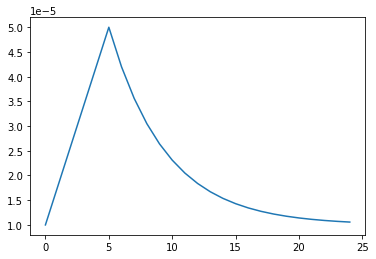

In [ ]:
EPOCHS=25
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## 9. Fonction de perte(multi-class)
for later, when we'll have the 7 types of plastic

In [ ]:
def categorical_focal_loss(gamma=2., alpha=.25):
    def categorical_focal_loss_fixed(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.cast(y_true, tf.float32) 
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return categorical_focal_loss_fixed

# **install models**

In [ ]:
!pip install image-classifiers

from classification_models.tfkeras import Classifiers

     |████████████████████████████████| 50 kB 4.5 MB/s 


In [ ]:
#from classification_models import Classifiers

n_classes = 1

resnet34, preprocess_input = Classifiers.get('resnet34')
base_model = resnet34((224, 224, 3), weights='imagenet',include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
#x = keras.layers.AveragePooling2D((7,7))(base_model.output)
output = Dense(n_classes, activation='sigmoid')(x)
model_resnet34 = keras.models.Model(inputs=[base_model.input], outputs=[output])
model_resnet34.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])



In [ ]:
h2=model_resnet34.fit(
    train_dataset,
    steps_per_epoch=df_train.shape[0]//BATCH_SIZE,
    validation_data=valid_dataset,
	  validation_steps=df_val.shape[0]//BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=20)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20
410/410 [==============================] - 219s 432ms/step - loss: 0.8727 - accuracy: 0.5591 - val_loss: 0.4794 - val_accuracy: 0.8990 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/20
410/410 [==============================] - 54s 131ms/step - loss: 0.8070 - accuracy: 0.5488 - val_loss: 0.4512 - val_accuracy: 0.8510 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/20
410/410 [==============================] - 54s 131ms/step - loss: 0.6878 - accuracy: 0.5982 - val_loss: 0.3944 - val_accuracy: 0.9038 - lr: 2.6000e-05

Epoch 00004: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/20
410/410 [==============================] - 54s 132ms/step - loss: 0.6269 - accuracy: 0.6445 - val_loss: 0.4572 - val_accuracy: 0.8510 - lr: 3.4000e-05

Epoch 00005: LearningRateSc

In [ ]:
model_resnet34.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 224, 224, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_102 (ZeroPaddin  (None, 230, 230, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                            

In [ ]:
model_resnet34.save('model_resnet34.h5')
print('Model Saved!')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model Saved!


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


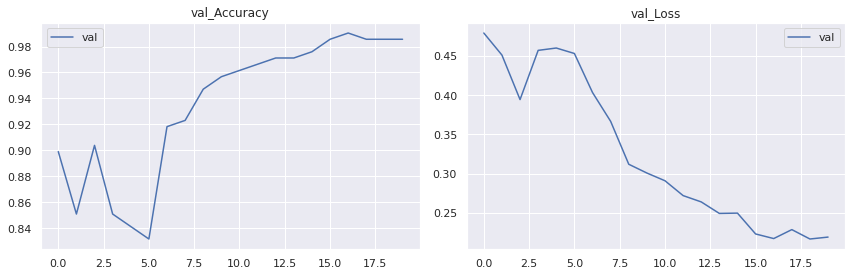

In [ ]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(h2.epoch,h2.history['val_accuracy'], label = 'val')
plt.title('val_Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(h2.epoch,h2.history['val_loss'], label = 'val')
plt.title('val_Loss')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


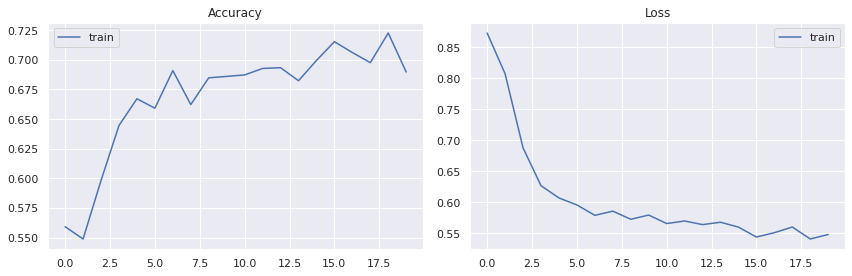

In [ ]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(h2.epoch,h2.history['accuracy'], label = 'train')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(h2.epoch,h2.history['loss'], label = 'train')
plt.title('Loss')
plt.tight_layout()
plt.show()

In [ ]:
model_resnet34.evaluate(test_dataset)

52/52 [==============================] - 26s 494ms/step - loss: 0.3055 - accuracy: 0.9320


[0.3054511547088623, 0.9320388436317444]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
classes=['PTE','PDHE']
Y_pred = model_resnet34.predict(test_dataset)
true_classes = df_test.label.values
print('Confusion Matrix')
y_pred=np.round(Y_pred)
cm=confusion_matrix(true_classes,y_pred)
cm

Confusion Matrix


array([[ 91,  13],
       [  1, 101]])

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


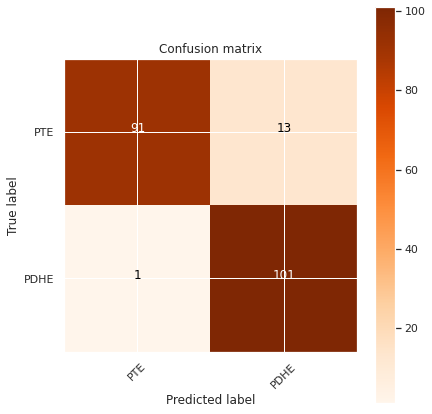

In [ ]:
plot_confusion_matrix(cm,classes)

In [ ]:
from tensorflow.keras.layers import Input


def SeResNeXT101():
    in_lay = Input(shape=(224,224,3))
    SeResNeXT101, preprocess_input = Classifiers.get('seresnext101')
    base_model = SeResNeXT101(input_shape=(224,224,3), weights='imagenet',include_top=False)
    
    pt_depth = 2048
    pt_features = base_model(in_lay)
    bn_features = BatchNormalization()(pt_features)

    attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.25)(bn_features))
    attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
    attn_layer = Conv2D(1, 
                        kernel_size = (1,1), 
                        padding = 'valid', 
                        activation = 'sigmoid')(attn_layer)
    # fan it out to all of the channels
    up_c2_w = np.ones((1, 1, 1, pt_depth))
    up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                   activation = 'linear', use_bias = False, weights = [up_c2_w])
    up_c2.trainable = False
    attn_layer = up_c2(attn_layer)

    mask_features = multiply([attn_layer, bn_features])
    gap_features = GlobalAveragePooling2D()(mask_features)
    gap_mask = GlobalAveragePooling2D()(attn_layer)
    # to account for missing values from the attention model
    gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
    gap_dr = Dropout(0.25)(gap)
    dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
    out_layer = Dense(1, activation = 'sigmoid')(dr_steps)
    retina_model = Model(inputs = [in_lay], outputs = [out_layer])
    return retina_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D,concatenate,Concatenate,multiply, LocallyConnected2D, Lambda)
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras import backend as K
import keras

In [ ]:
with strategy.scope():
  SRNXT101=SeResNeXT101()
  SRNXT101.compile(
                    optimizer=tf.optimizers.Adam(),
                    loss="binary_crossentropy",
                    metrics=['accuracy',
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.Precision(),   
                            tf.keras.metrics.AUC()
                           ])

193011712/192995976 [==============================] - 23s 0us/step


# Training

In [ ]:
h1=SRNXT101.fit(
    train_dataset,
    steps_per_epoch=df_train.shape[0]//BATCH_SIZE,
    validation_data=valid_dataset,
	  validation_steps=df_val.shape[0]//BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=30)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/30
410/410 [==============================] - 452s 803ms/step - loss: 0.6147 - accuracy: 0.6701 - recall: 0.7385 - precision: 0.6812 - auc: 0.7119 - val_loss: 0.1040 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_auc: 0.0000e+00 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/30
410/410 [==============================] - 315s 768ms/step - loss: 0.2961 - accuracy: 0.8902 - recall: 0.8897 - precision: 0.8919 - auc: 0.9547 - val_loss: 0.0039 - val_accuracy: 1.0000 - val_recall: 1.0000 - val_precision: 1.0000 - val_auc: 0.0000e+00 - lr: 1.8000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/30
410/410 [==============================] - 309s 754ms/step - loss: 0.0921 - accuracy: 0.9732 - recall: 0.9739 - precision: 0.9715 - auc: 0.9955 - val_loss: 8.6053e-04 - val_accuracy: 1.0000

In [ ]:
SRNXT101.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 7, 7, 2048)   47044272    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 2048)  8192        ['model[0][0]']                  
 Normalization)                                                                                   
                                                                                            

In [ ]:
h1.model

In [ ]:
# save model
#path ='/content/drive/MyDrive/data/dataset/SRNXT101.h5'
SRNXT101.save('SRNXT101.h5')
print('Model Saved!')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model Saved!


In [ ]:
# load model
savedModel=load_model('gfgModel.h5')
savedModel.summary()

In [ ]:
# load model
savedModel=load_model('/content/drive/MyDrive/pretrained_models/SRNXT101.h5')
savedModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 7, 7, 2048)   47044272    ['input_1[0][0]']                
                                                                                                  
 batch_normalization_104 (Batch  (None, 7, 7, 2048)  8192        ['model[0][0]']                  
 Normalization)                                                                                   
                                                                                            

## Affichage des courbes 

In [ ]:
print(h1.history.keys())


dict_keys(['loss', 'accuracy', 'recall', 'precision', 'auc', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision', 'val_auc', 'lr'])


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


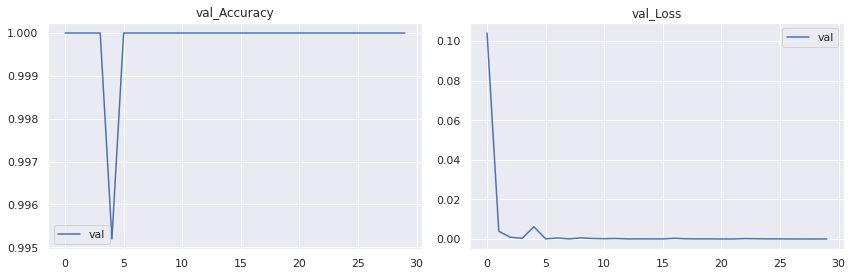

In [ ]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(h1.epoch,h1.history['val_accuracy'], label = 'val')
plt.title('val_Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(h1.epoch,h1.history['val_loss'], label = 'val')
plt.title('val_Loss')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


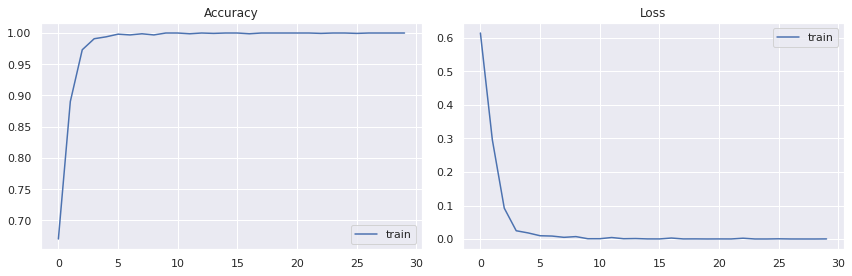

In [ ]:
import seaborn as sns
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(h1.epoch,h1.history['accuracy'], label = 'train')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(h1.epoch,h1.history['loss'], label = 'train')
plt.title('Loss')
plt.tight_layout()
plt.show()

In [ ]:
SRNXT101.evaluate(test_dataset)

52/52 [==============================] - 27s 495ms/step - loss: 3.0092e-06 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000


[3.009247393492842e-06, 1.0, 1.0, 1.0, 1.0]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
classes=['PTE','PDHE']
Y_pred = SRNXT101.predict(test_dataset)
true_classes = df_test.label.values
print('Confusion Matrix')
cm=confusion_matrix(true_classes,y_pred)
cm

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
classes=['PTE','PDHE']
Y_pred = savedModel.predict(test_dataset)
true_classes = df_test.label.values
print('Confusion Matrix')
y_pred=np.round(Y_pred)
cm2=confusion_matrix(true_classes,y_pred)
cm2

Confusion Matrix


array([[104,   0],
       [  0, 102]])

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
classes=['PTE','PDHE']
Y_pred = SRNXT101.predict(test_dataset)
true_classes = df_test.label.values
print('Confusion Matrix')
y_pred=np.round(Y_pred)
cm2=confusion_matrix(true_classes,y_pred)
cm2

Confusion Matrix


array([[82, 22],
       [65, 37]])

Confusion matrix, without normalization


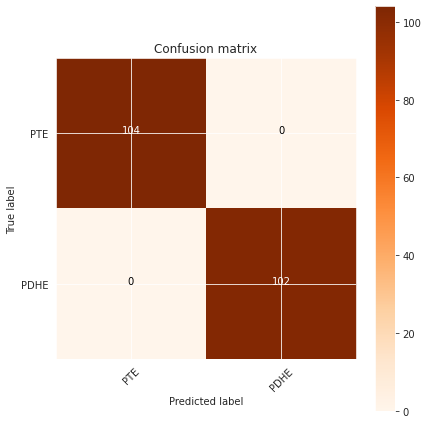

In [ ]:
plot_confusion_matrix(cm2,classes)

In [ ]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
model = ResNet18((224, 224, 3), weights='imagenet')